[Cook County Assessors Office Code](https://gitlab.com/ccao-data-science---modeling)

Data Sources:

* [Cook County GIS Open Data](https://hub-cookcountyil.opendata.arcgis.com/)

In [1]:
# import packages
import csv, datetime, glob, joblib, math, pickle, pydot, time, os, sklearn

from dask.distributed import Client, progress
from datetime import datetime
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from tqdm import tqdm

In [2]:
dataset_dropdown = widgets.Dropdown(
    options = glob.glob("./data/processed/*.pkl"),
    value = "./data/processed/Cleaned_Chicago_Sales.pkl",
    description = "Data: "
)
display(dataset_dropdown)

Dropdown(description='Data: ', index=2, options=('./data/processed/Cleaned_Chicago_Sales_wACS.pkl', './data/pr…

In [69]:
# Data from: https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Sales-Data/5pge-nu6u
dataset = dataset_dropdown.value
print("Loading data from {}".format(dataset))
ml_df = pd.read_pickle(dataset)
print("Data frame has {} rows and {} columns".format(len(ml_df), len(ml_df.columns)))
ml_df.head()

Loading data from ./data/processed/Cleaned_Chicago_Sales_wACS.pkl
Data frame has 339204 rows and 225 columns


,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,...,NonFamilyHouseholdsMedianIncome,NonFamilyHouseholdsMeanIncome,MedianWorkerEarnings,HealthInsuranceCoverage,HealthInsuranceCoverage-Private,HealthInsuranceCoverage-Public,FamiliesBelowPovertyLevel,MarriedCouplesBelowPovertyLevel,PeopleIncomeBelowPovertyLevel,ChildrenUnderPovertyLevel
0,907671888,211,13,4500.0,77,3.0,6.0,2.0,2.0,24.0,...,14806.0,20590.0,22252.0,85.199997,29.600000,60.400002,27.700001,11.5,34.099998,43.900002
1,-16803040,204,100,33898.0,25,5.0,0.0,2.0,4.0,11.0,...,48929.0,106485.0,60333.0,96.199997,89.599998,21.400000,2.600000,1.0,1.900000,1.700000
2,-1605782160,208,12,3720.0,74,3.0,0.0,2.0,6.0,9.0,...,82589.0,97714.0,36996.0,95.800003,92.800003,9.000000,0.000000,0.0,12.400000,0.000000
3,1560820864,204,34,16079.0,28,1.0,0.0,3.0,1.0,7.0,...,40882.0,54363.0,50197.0,96.199997,85.500000,25.100000,2.600000,3.0,5.600000,5.700000
4,-44469280,204,42,7560.0,71,1.0,0.0,2.0,1.0,6.0,...,77222.0,77490.0,45552.0,95.300003,82.699997,21.400000,1.600000,0.0,2.900000,0.000000


In [70]:
ml_df = pd.read_pickle(dataset)
drop_these = ["PIN", "Sale Date", 
              "Estimate (Land)", "Estimate (Building)", 
              "Deed No.", "Pure Market Filter"]
tree_slider = widgets.SelectionSlider(
    options=[ 2**i for i in range(1,10)],
    value=64,
    description="N Trees",
)
start_date, end_date = min(ml_df["Sale Date"]), max(ml_df["Sale Date"])
dates = pd.date_range(start_date, end_date, freq="D")
dates_slider = widgets.SelectionRangeSlider(
    options = [ (date.strftime("%d %b %Y"), date) for date in dates ],
    index=(0,len(dates)-1),
    layout={'width':'500px'}
)
prices = ml_df["Sale Price"].to_numpy()
price_range = range( math.floor(min(prices)/1000), math.ceil(max(prices)/1000), 1)
price_slider = widgets.SelectionRangeSlider(
    options =  price_range,
    index=(0,len(price_range)-1),
    layout={'width':'500px'}
)
display(tree_slider, dates_slider, price_slider)

SelectionSlider(description='N Trees', index=5, options=(2, 4, 8, 16, 32, 64, 128, 256, 512), value=64)

SelectionRangeSlider(index=(0, 2554), layout=Layout(width='500px'), options=(('02 Jan 2013', Timestamp('2013-0…

SelectionRangeSlider(index=(0, 9389), layout=Layout(width='500px'), options=(10, 11, 12, 13, 14, 15, 16, 17, 1…

In [71]:
ml_df = pd.read_pickle(dataset)
date_slider_i = dates_slider.index
start, end = dates[date_slider_i[0]], dates[date_slider_i[1]]
#print(start, end)
ml_df = ml_df[ml_df["Sale Date"] <= end]
ml_df = ml_df[ml_df["Sale Date"] >= start]
price_i = price_slider.index
low_price, high_price = price_range[price_i[0]], price_range[price_i[1]]
ml_df = ml_df[ml_df["Sale Price"] >= low_price*1000]
ml_df = ml_df[ml_df["Sale Price"] <= high_price*1000]

ml_df = ml_df.drop(drop_these, axis=1)
print("Data frame has {} rows and {} columns".format(len(ml_df), len(ml_df.columns)))
ml_df.head()

Data frame has 339203 rows and 219 columns


,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,...,NonFamilyHouseholdsMedianIncome,NonFamilyHouseholdsMeanIncome,MedianWorkerEarnings,HealthInsuranceCoverage,HealthInsuranceCoverage-Private,HealthInsuranceCoverage-Public,FamiliesBelowPovertyLevel,MarriedCouplesBelowPovertyLevel,PeopleIncomeBelowPovertyLevel,ChildrenUnderPovertyLevel
0,211,13,4500.0,77,3.0,6.0,2.0,2.0,24.0,12.0,...,14806.0,20590.0,22252.0,85.199997,29.600000,60.400002,27.700001,11.5,34.099998,43.900002
1,204,100,33898.0,25,5.0,0.0,2.0,4.0,11.0,4.0,...,48929.0,106485.0,60333.0,96.199997,89.599998,21.400000,2.600000,1.0,1.900000,1.700000
2,208,12,3720.0,74,3.0,0.0,2.0,6.0,9.0,5.0,...,82589.0,97714.0,36996.0,95.800003,92.800003,9.000000,0.000000,0.0,12.400000,0.000000
3,204,34,16079.0,28,1.0,0.0,3.0,1.0,7.0,3.0,...,40882.0,54363.0,50197.0,96.199997,85.500000,25.100000,2.600000,3.0,5.600000,5.700000
4,204,42,7560.0,71,1.0,0.0,2.0,1.0,6.0,5.0,...,77222.0,77490.0,45552.0,95.300003,82.699997,21.400000,1.600000,0.0,2.900000,0.000000


# Random Forest

In [72]:
ml_df.describe()

,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,...,NonFamilyHouseholdsMedianIncome,NonFamilyHouseholdsMeanIncome,MedianWorkerEarnings,HealthInsuranceCoverage,HealthInsuranceCoverage-Private,HealthInsuranceCoverage-Public,FamiliesBelowPovertyLevel,MarriedCouplesBelowPovertyLevel,PeopleIncomeBelowPovertyLevel,ChildrenUnderPovertyLevel
count,339203.000000,339203.000000,3.392030e+05,339203.000000,339203.000000,339203.000000,339203.000000,339203.000000,339203.000000,339203.000000,...,328501.000000,339203.000000,339151.000000,339203.000000,339203.000000,339203.000000,339203.000000,339203.000000,339203.000000,339203.000000
mean,220.131723,106.619337,6.885363e+03,45.756181,2.126243,0.409705,1.942439,1.178946,7.145187,3.569287,...,40479.460938,53519.031250,39178.343750,90.349831,66.598068,33.630379,10.690272,6.076194,13.384094,17.786873
std,29.590377,99.144176,1.256670e+04,23.964815,1.273946,1.067684,0.780957,0.634165,3.438778,1.565590,...,17173.089844,23079.835938,15066.007812,6.341203,18.667154,13.111530,9.962968,7.301517,10.798603,16.969040
min,202.000000,10.000000,1.490000e+02,10.000000,1.000000,-5.000000,1.000000,1.000000,2.000000,1.000000,...,8441.000000,9873.000000,3150.000000,63.299999,12.400000,1.200000,0.000000,0.000000,0.400000,0.000000
25%,203.000000,32.000000,3.720000e+03,24.000000,1.000000,0.000000,1.000000,1.000000,5.000000,3.000000,...,28021.000000,37921.000000,28899.000000,86.900002,53.700001,24.400000,3.500000,1.200000,5.400000,4.000000
50%,205.000000,80.000000,5.000000e+03,37.000000,2.000000,0.000000,2.000000,1.000000,6.000000,3.000000,...,38272.000000,49268.000000,35951.000000,91.500000,69.000000,32.000000,7.500000,3.800000,10.300000,12.500000
75%,211.000000,141.000000,7.910000e+03,72.000000,2.000000,0.000000,2.000000,1.000000,8.000000,4.000000,...,50486.000000,62788.000000,45755.000000,95.400002,82.199997,41.400002,15.000000,8.300000,18.799999,27.799999
max,295.000000,600.000000,2.980767e+06,77.000000,8.000000,6.000000,4.000000,6.000000,241.000000,90.000000,...,139500.000000,233353.000000,125170.000000,100.000000,98.500000,81.099998,72.199997,73.300003,73.699997,96.699997


In [73]:
label_cols = ["Sale Price"]

labels = np.array(ml_df[label_cols])
features = ml_df.drop(label_cols, axis=1)
feature_list = list(features.columns)
#print(feature_list)
features = np.array(features)

In [74]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(np.nan_to_num(features), labels, test_size = 0.25, random_state = 42)
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (254402, 218)
Training Labels Shape: (254402,)
Testing Features Shape: (84801, 218)
Testing Labels Shape: (84801,)


In [75]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
ntrees = tree_slider.value
print("Running RFR with {} trees".format(ntrees))
rf = RandomForestRegressor(n_estimators = ntrees, random_state = 42)
# Train the model on training data
with Client(processes=False, threads_per_worker=5, n_workers=1, memory_limit='10GB') as client:
    with joblib.parallel_backend("dask"):
        rf.fit(train_features, train_labels)
pickle.dump( rf, open( "rfr.pkl", "wb" ) )

Running RFR with 64 trees


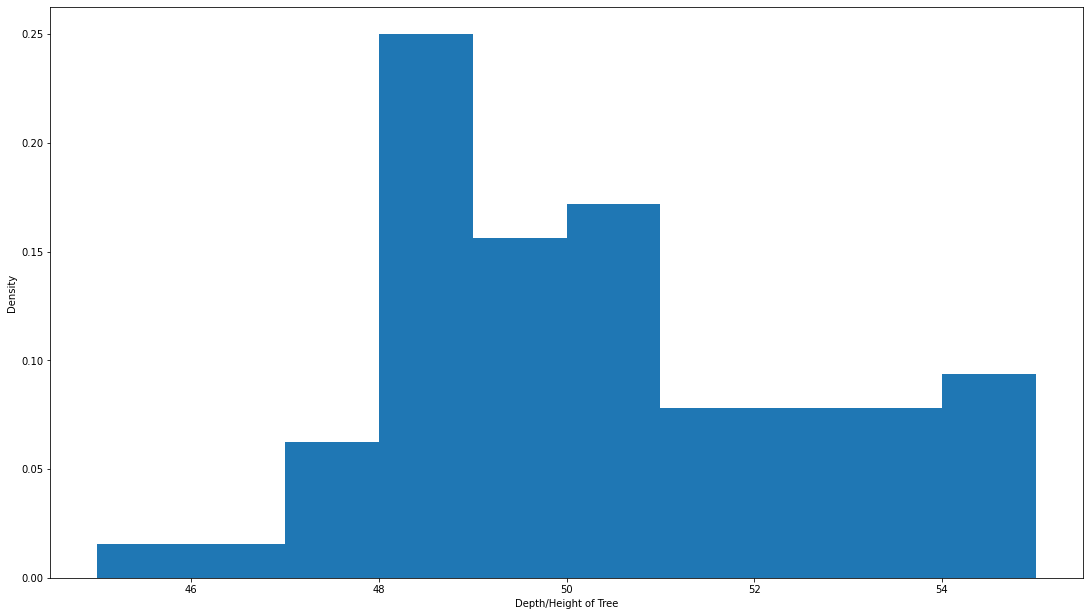

In [76]:
plt.hist([rf.estimators_[i].get_depth() for i in range(ntrees)],density=True)
plt.xlabel("Depth/Height of Tree")
plt.ylabel("Density")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

Mean Sale Price in Training Set: $301123.60
Mean Sale Price in Test Set: $302247.24
Mean Error: $ 909.08


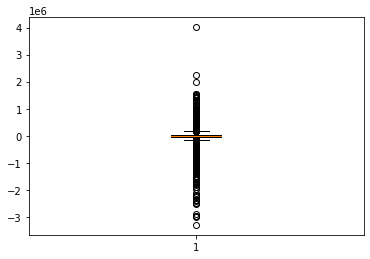

In [77]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = predictions-test_labels
print("Mean Sale Price in Training Set: ${:7.2f}".format(np.mean(train_labels)))
print("Mean Sale Price in Test Set: ${:7.2f}".format(np.mean(test_labels)))
print('Mean Error: ${:7.2f}'.format(np.mean(errors)))
plt.boxplot(errors)
plt.show()

Mean Absolute Error: $63346.92


Task was destroyed but it is pending!
task: <Task pending name='Task-291' coro=<HTTP1ServerConnection._server_request_loop() running at /home/dijkstra/Nextcloud/Documents/UIUC/Y2F/ACE592/Project/env/lib/python3.8/site-packages/tornado/http1connection.py:823> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f7557d0e940>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /home/dijkstra/Nextcloud/Documents/UIUC/Y2F/ACE592/Project/env/lib/python3.8/site-packages/tornado/ioloop.py:688]>
Task was destroyed but it is pending!
task: <Task pending name='Task-378' coro=<RequestHandler._execute() running at /home/dijkstra/Nextcloud/Documents/UIUC/Y2F/ACE592/Project/env/lib/python3.8/site-packages/tornado/web.py:1704> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f75620efcd0>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /home/dijkstra/Nextcloud/Documents/UIUC/Y2F/ACE592/Project/env/lib/python3.8/site-packages/tornado/web.py:2326]>


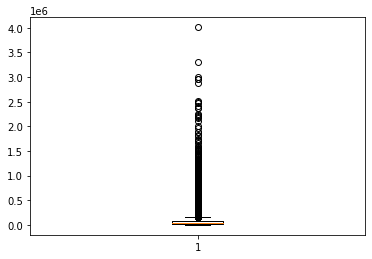

In [78]:
# Print out the mean absolute error (mae)
mae = np.mean(np.abs(errors))
print('Mean Absolute Error: ${:7.2f}'.format(mae))
plt.boxplot(np.abs(errors))
plt.show()

MAPE: 38.38%


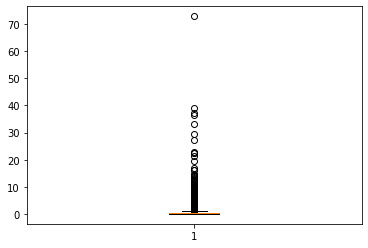

In [79]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (np.abs(errors) / test_labels)
# Calculate and display accuracy
mape = np.mean(mape)
print('MAPE: {:3.2f}%'.format(mape))
plt.boxplot(np.abs(errors)/test_labels)
plt.show()

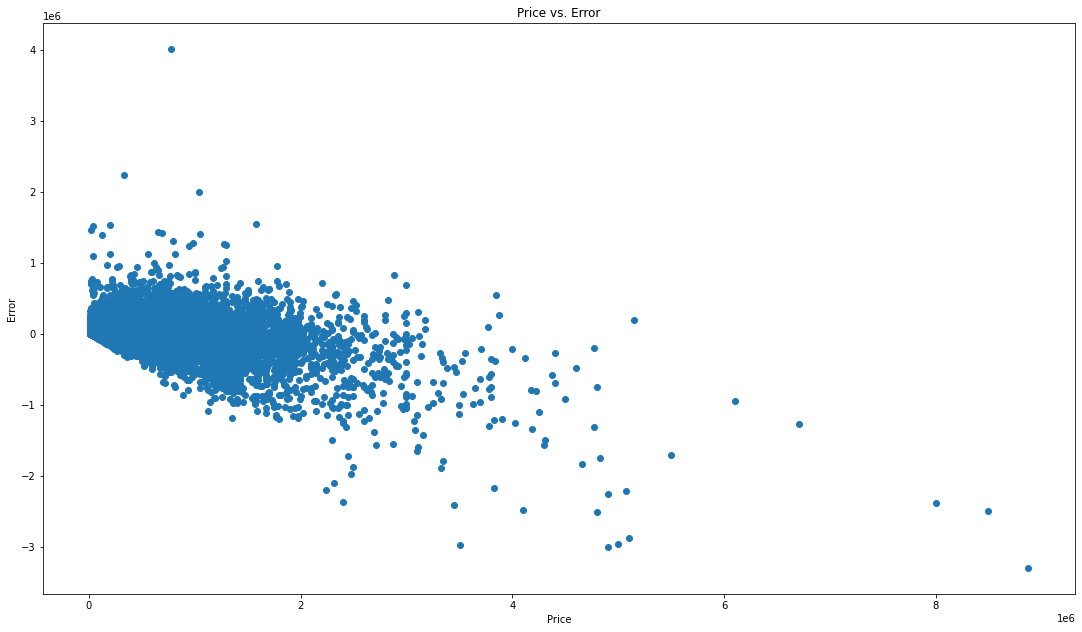

In [80]:
plt.scatter(test_labels, errors)
plt.title("Price vs. Error")
plt.xlabel("Price")
plt.ylabel("Error")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

Feature ranking:
 1. feature 207 = FamiliesPerCaptiaIncome        (0.3014)
 2. feature 136 = Square of Building Square Feet (0.0568)
 3. feature 33 = Census Tract                   (0.0566)
 4. feature 134 = Log of Building Square Feet    (0.0557)
 5. feature 204 = FamiliesIncome200k+            (0.0492)
 6. feature 135 = SQRT of Building Square Feet   (0.0451)
 7. feature 30 = Building Square Feet           (0.0419)
 8. feature 153 = Square of Latitude             (0.0284)
 9. feature 31 = Longitude                      (0.0226)
10. feature 156 = Square of Longitude            (0.0202)
11. feature 155 = SQRT of Longitude              (0.0152)
12. feature 152 = SQRT of Latitude               (0.0127)
13. feature 42 = Sale Quarter                   (0.0123)
14. feature 154 = Log of Longitude               (0.0120)
15. feature 151 = Log of Latitude                (0.0110)
16. feature 32 = Latitude                       (0.0108)
17. feature 170 = CommutingToWork-PublicTransit  (0.0098)
18

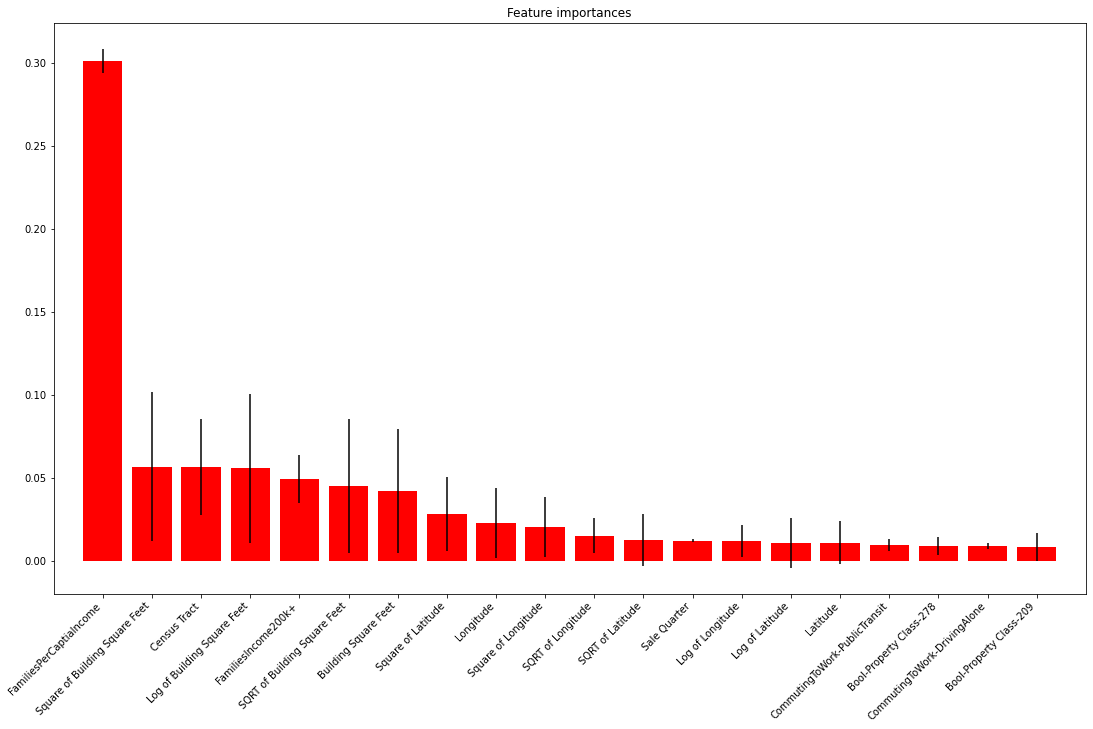

In [81]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1][:20]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)):
    print("{:2d}. feature {:2d} = {:<30s} ({:1.4f})".format(f+1, indices[f], feature_list[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), [ feature_list[i] for i in indices], rotation=45, ha="right")
plt.xlim([-1, len(indices)])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

Mean error for class 202 is $2375.98 and mean absolute error is $45607.96
Mean error for class 203 is $1379.63 and mean absolute error is $49572.07
Mean error for class 204 is $3794.64 and mean absolute error is $79360.35
Mean error for class 205 is $-1909.43 and mean absolute error is $69313.72
Mean error for class 206 is $-3903.96 and mean absolute error is $138043.52
Mean error for class 207 is $-5362.02 and mean absolute error is $46705.38
Mean error for class 208 is $-34366.55 and mean absolute error is $176999.32
Mean error for class 209 is $-34599.63 and mean absolute error is $370114.98
Mean error for class 210 is $-797.13 and mean absolute error is $68659.84
Mean error for class 211 is $3278.81 and mean absolute error is $84366.26
Mean error for class 212 is $45274.45 and mean absolute error is $154383.30
Mean error for class 234 is $-2665.19 and mean absolute error is $40927.82
Mean error for class 278 is $-515.36 and mean absolute error is $73493.35
Mean error for class 295 

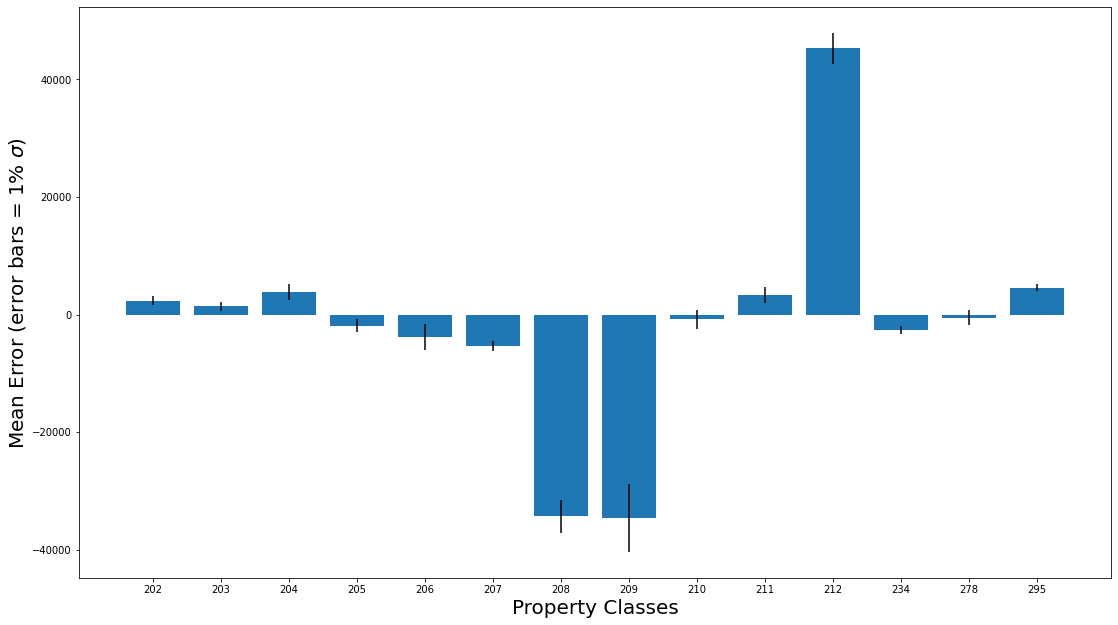

In [82]:
feature_list = list(feature_list)
index = feature_list.index('Property Class')
classes = set()
for i in range(len(test_features)):
    classes.add(int(test_features[i][index]))
pcerrors = {}
#print(classes)
for elem in classes:
    pcerrors[elem] = {}
    pcerrors[elem]["error"] = []
    pcerrors[elem]["abs_err"] = []
abs_error = np.abs(errors)
for i in range(len(test_features)):
    pc = int(test_features[i][index])
    pcerrors[pc]["error"].append(errors[i])
    pcerrors[pc]["abs_err"].append(abs_error[i])
classes = list(classes)
classes.sort()
for elem in classes:
    print("Mean error for class {} is ${:7.2f} and mean absolute error is ${:7.2f}".format(elem, np.mean(pcerrors[elem]["error"]), np.mean(pcerrors[elem]["abs_err"]) ))
plt.bar([str(i) for i in classes], [np.mean(pcerrors[elem]["error"]) for elem in classes], yerr=[np.std(pcerrors[elem]["error"])/100 for elem in classes])
plt.xlabel("Property Classes", fontsize=20)
plt.ylabel("Mean Error (error bars = 1% $\sigma$)", fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

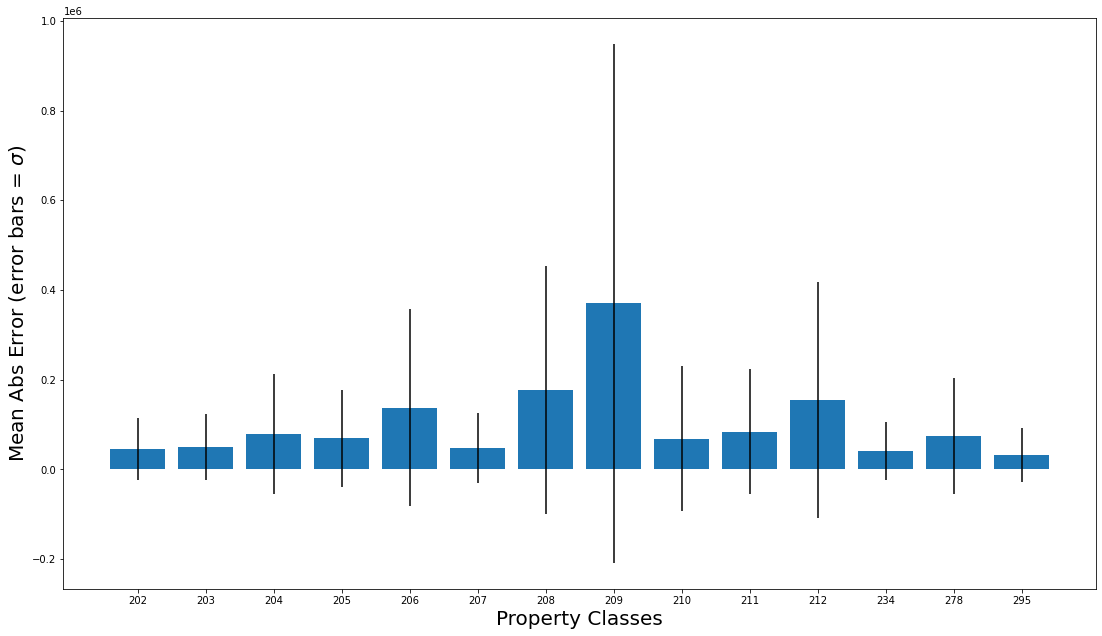

In [83]:
plt.bar([str(i) for i in classes], [np.mean(pcerrors[elem]["abs_err"]) for elem in classes], yerr=[np.std(pcerrors[elem]["error"]) for elem in classes])
plt.xlabel("Property Classes", fontsize=20)
plt.ylabel("Mean Abs Error (error bars = $\sigma$)", fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

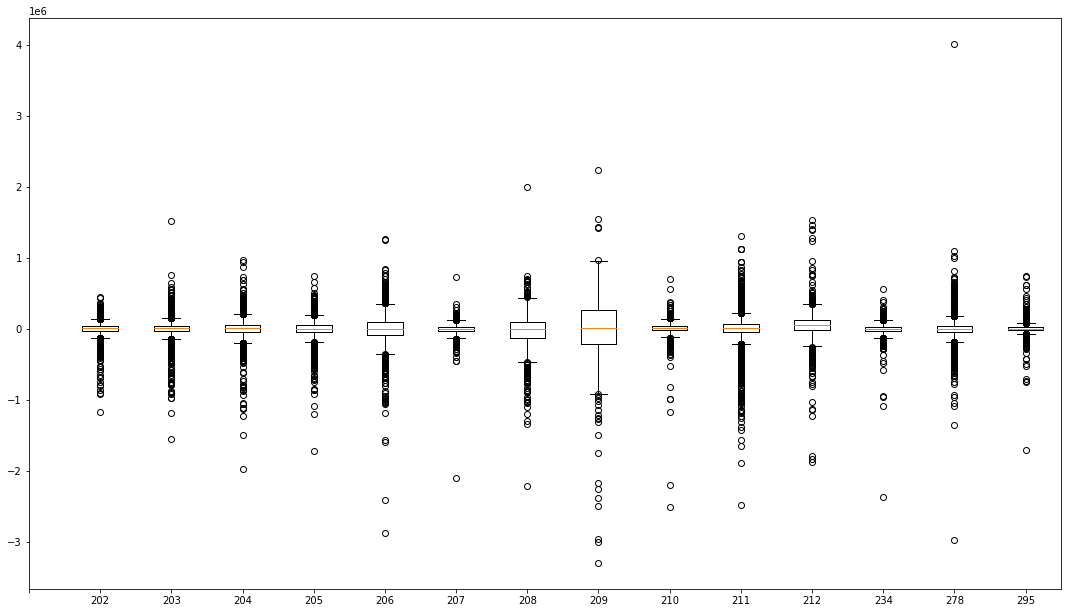

In [84]:
to_plt = [ pcerrors[pc]["error"] for pc in classes ]
plt.boxplot(to_plt)
plt.xticks(range(len(classes)+1), [""]+classes)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [85]:
# check if depth is too high
if np.mean([rf.estimators_[0].get_depth() for i in range(ntrees)]) < 8:
    tree = rf.estimators_[0]
    export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
    (graph, ) = pydot.graph_from_dot_file('tree.dot')
    graph.write_png('tree.png')
else:
    print("Tree height is too large to realistically plot.")

Tree height is too large to realistically plot.
